In [1]:
from __future__ import print_function, unicode_literals, absolute_import, division
import numpy as np
import matplotlib
matplotlib.rcParams["image.interpolation"] = None
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

from glob import glob
from tqdm import tqdm
from tifffile import imread
from csbdeep.utils import Path, download_and_extract_zip_file

from stardist import fill_label_holes, relabel_image_stardist, random_label_cmap
from stardist.matching import matching_dataset

np.random.seed(42)
lbl_cmap = random_label_cmap()

# Data

This notebook demonstrates how the training data for *StarDist* should look like and whether the annotated objects can be appropriately described by star-convex polygons. 

<div class="alert alert-block alert-info">
The training data that needs to be provided for StarDist consists of corresponding pairs of raw images and pixelwise annotated ground truth images (masks), where every pixel has a unique integer value indicating the object id (or 0 for background). 
</div>

For this demo we will download the file `dsb2018.zip` that contains the respective train and test images with associated ground truth labels as used in [our paper](https://arxiv.org/abs/1806.03535).
They are a subset of the `stage1_train` images from the Kaggle 2018 Data Science Bowl, which are [available in full](https://data.broadinstitute.org/bbbc/BBBC038/) from the [Broad Bioimage Benchmark Collection](https://data.broadinstitute.org/bbbc/).

In [2]:
download_and_extract_zip_file(
    url       = 'https://github.com/anrcrocoval/deeplearning/raw/master/Obtaining3Dannotationfrom2DlabelData/data.zip',
    targetdir = 'data',
    verbose   = 1,
)

Files missing, downloading... extracting... done.


In [3]:
X = sorted(glob('data/data/train/image/*.tif'))
Y = sorted(glob('data/data/train/mask/*.tif'))
assert all(Path(x).name==Path(y).name for x,y in zip(X,Y))
print(len(X))

3


Load only a small subset

In [4]:
X, Y = X[:3], Y[:3]

In [5]:
X = list(map(imread,X))
Y = list(map(imread,Y))

# Example image

In [6]:
i=0
img, lbl = X[i], fill_label_holes(Y[i])


In [7]:

# assumed axes ordering of img and lbl is: YX(C)

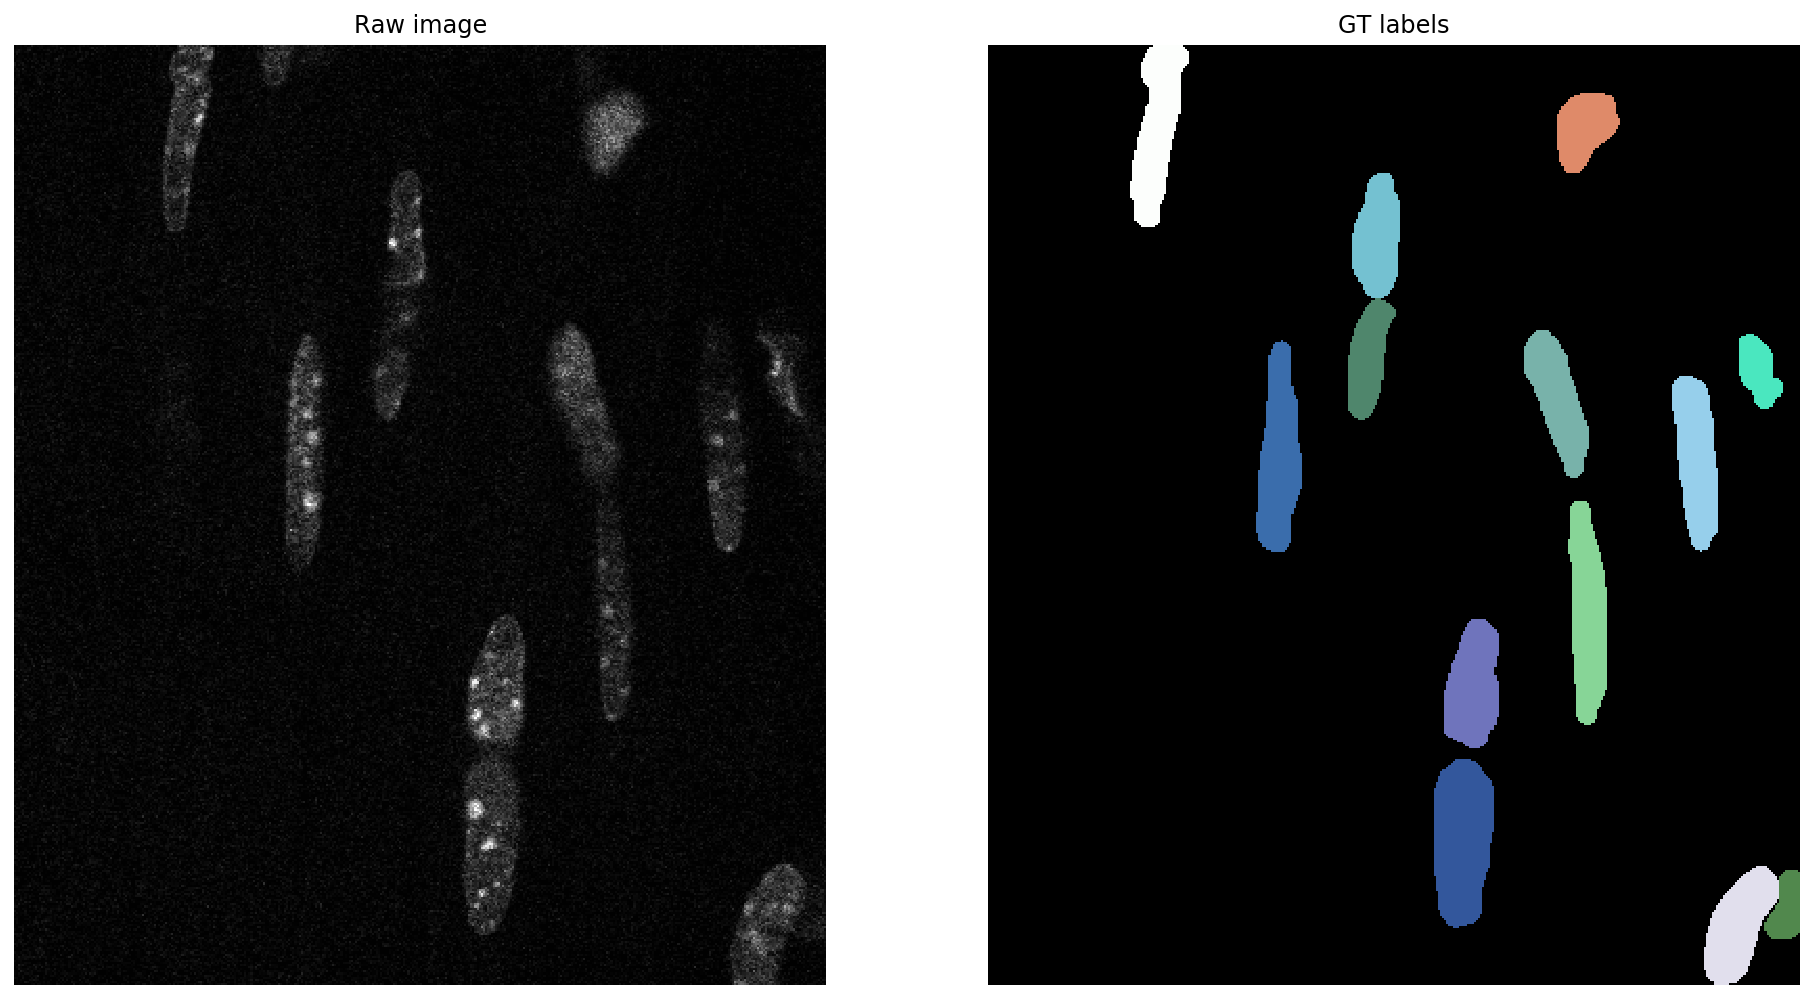

In [8]:
plt.figure(figsize=(16,10))
plt.subplot(121); plt.imshow(img,cmap='gray');   plt.axis('off'); plt.title('Raw image')
plt.subplot(122); plt.imshow(lbl,cmap=lbl_cmap); plt.axis('off'); plt.title('GT labels')
None;

# Fitting ground-truth labels with star-convex polygons

In [9]:
n_rays = [2**i for i in range(2,8)]
scores = []
for r in tqdm(n_rays):
    Y_reconstructed = [relabel_image_stardist(lbl, n_rays=r) for lbl in Y]
    mean_iou = matching_dataset(Y, Y_reconstructed, thresh=0, show_progress=False).mean_true_score
    scores.append(mean_iou)

100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:07<00:00,  1.33s/it]


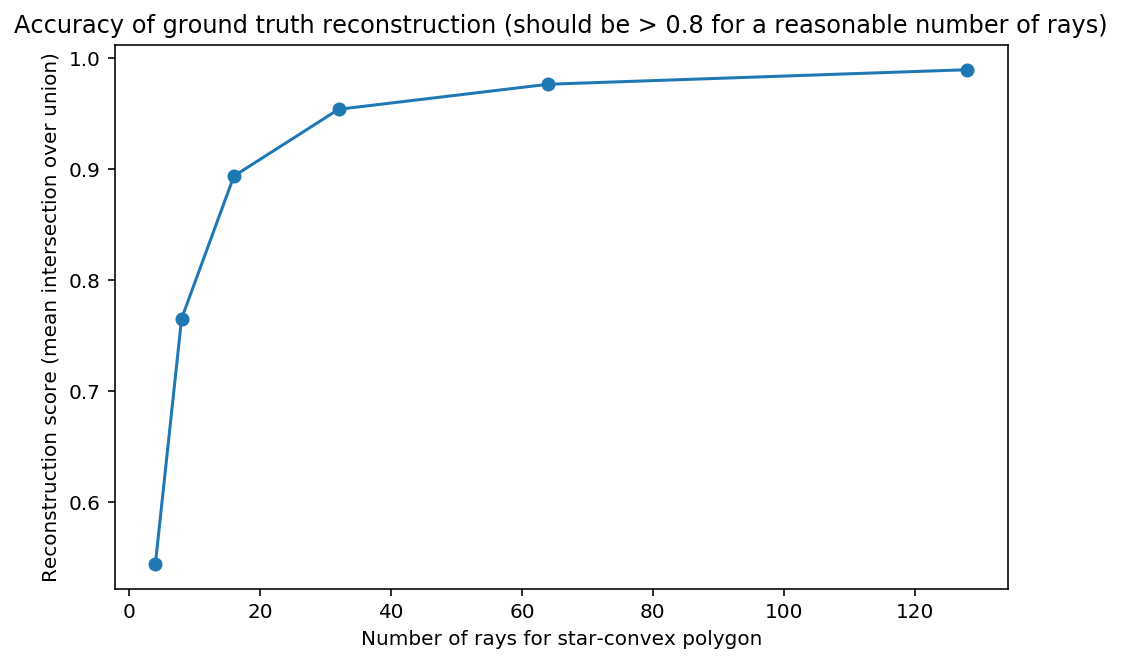

In [10]:
plt.figure(figsize=(8,5))
plt.plot(n_rays, scores, 'o-')
plt.xlabel('Number of rays for star-convex polygon')
plt.ylabel('Reconstruction score (mean intersection over union)')
plt.title("Accuracy of ground truth reconstruction (should be > 0.8 for a reasonable number of rays)")
None;

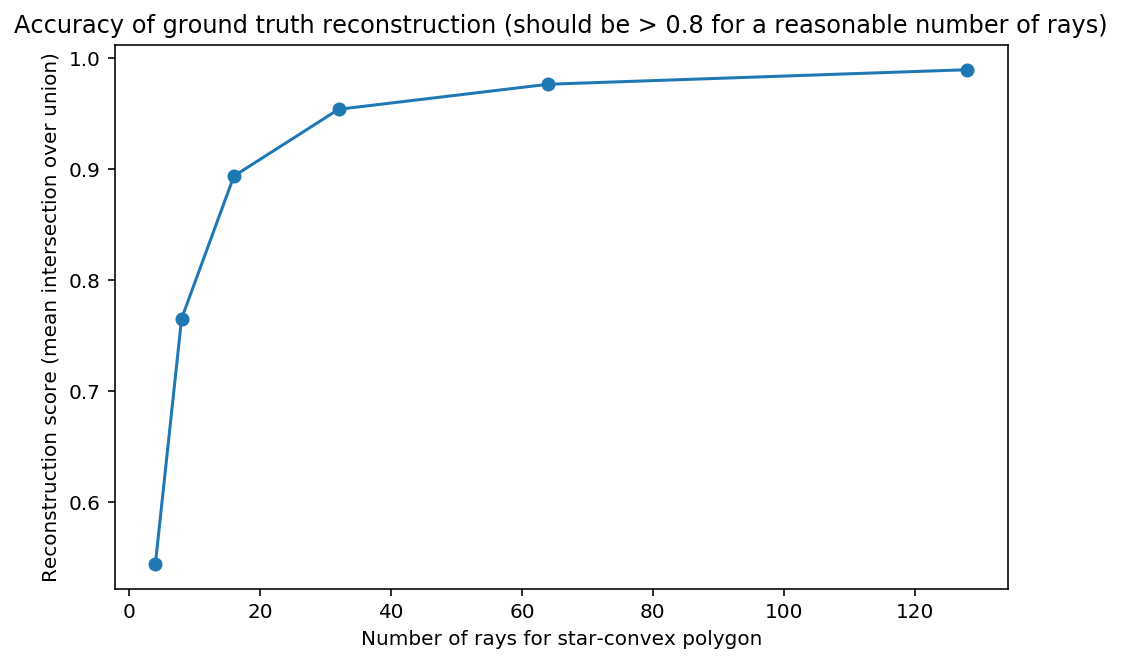

In [11]:
plt.figure(figsize=(8,5))
plt.plot(n_rays, scores, 'o-')
plt.xlabel('Number of rays for star-convex polygon')
plt.ylabel('Reconstruction score (mean intersection over union)')
plt.title("Accuracy of ground truth reconstruction (should be > 0.8 for a reasonable number of rays)")
None;

## Example image reconstructed with various number of rays

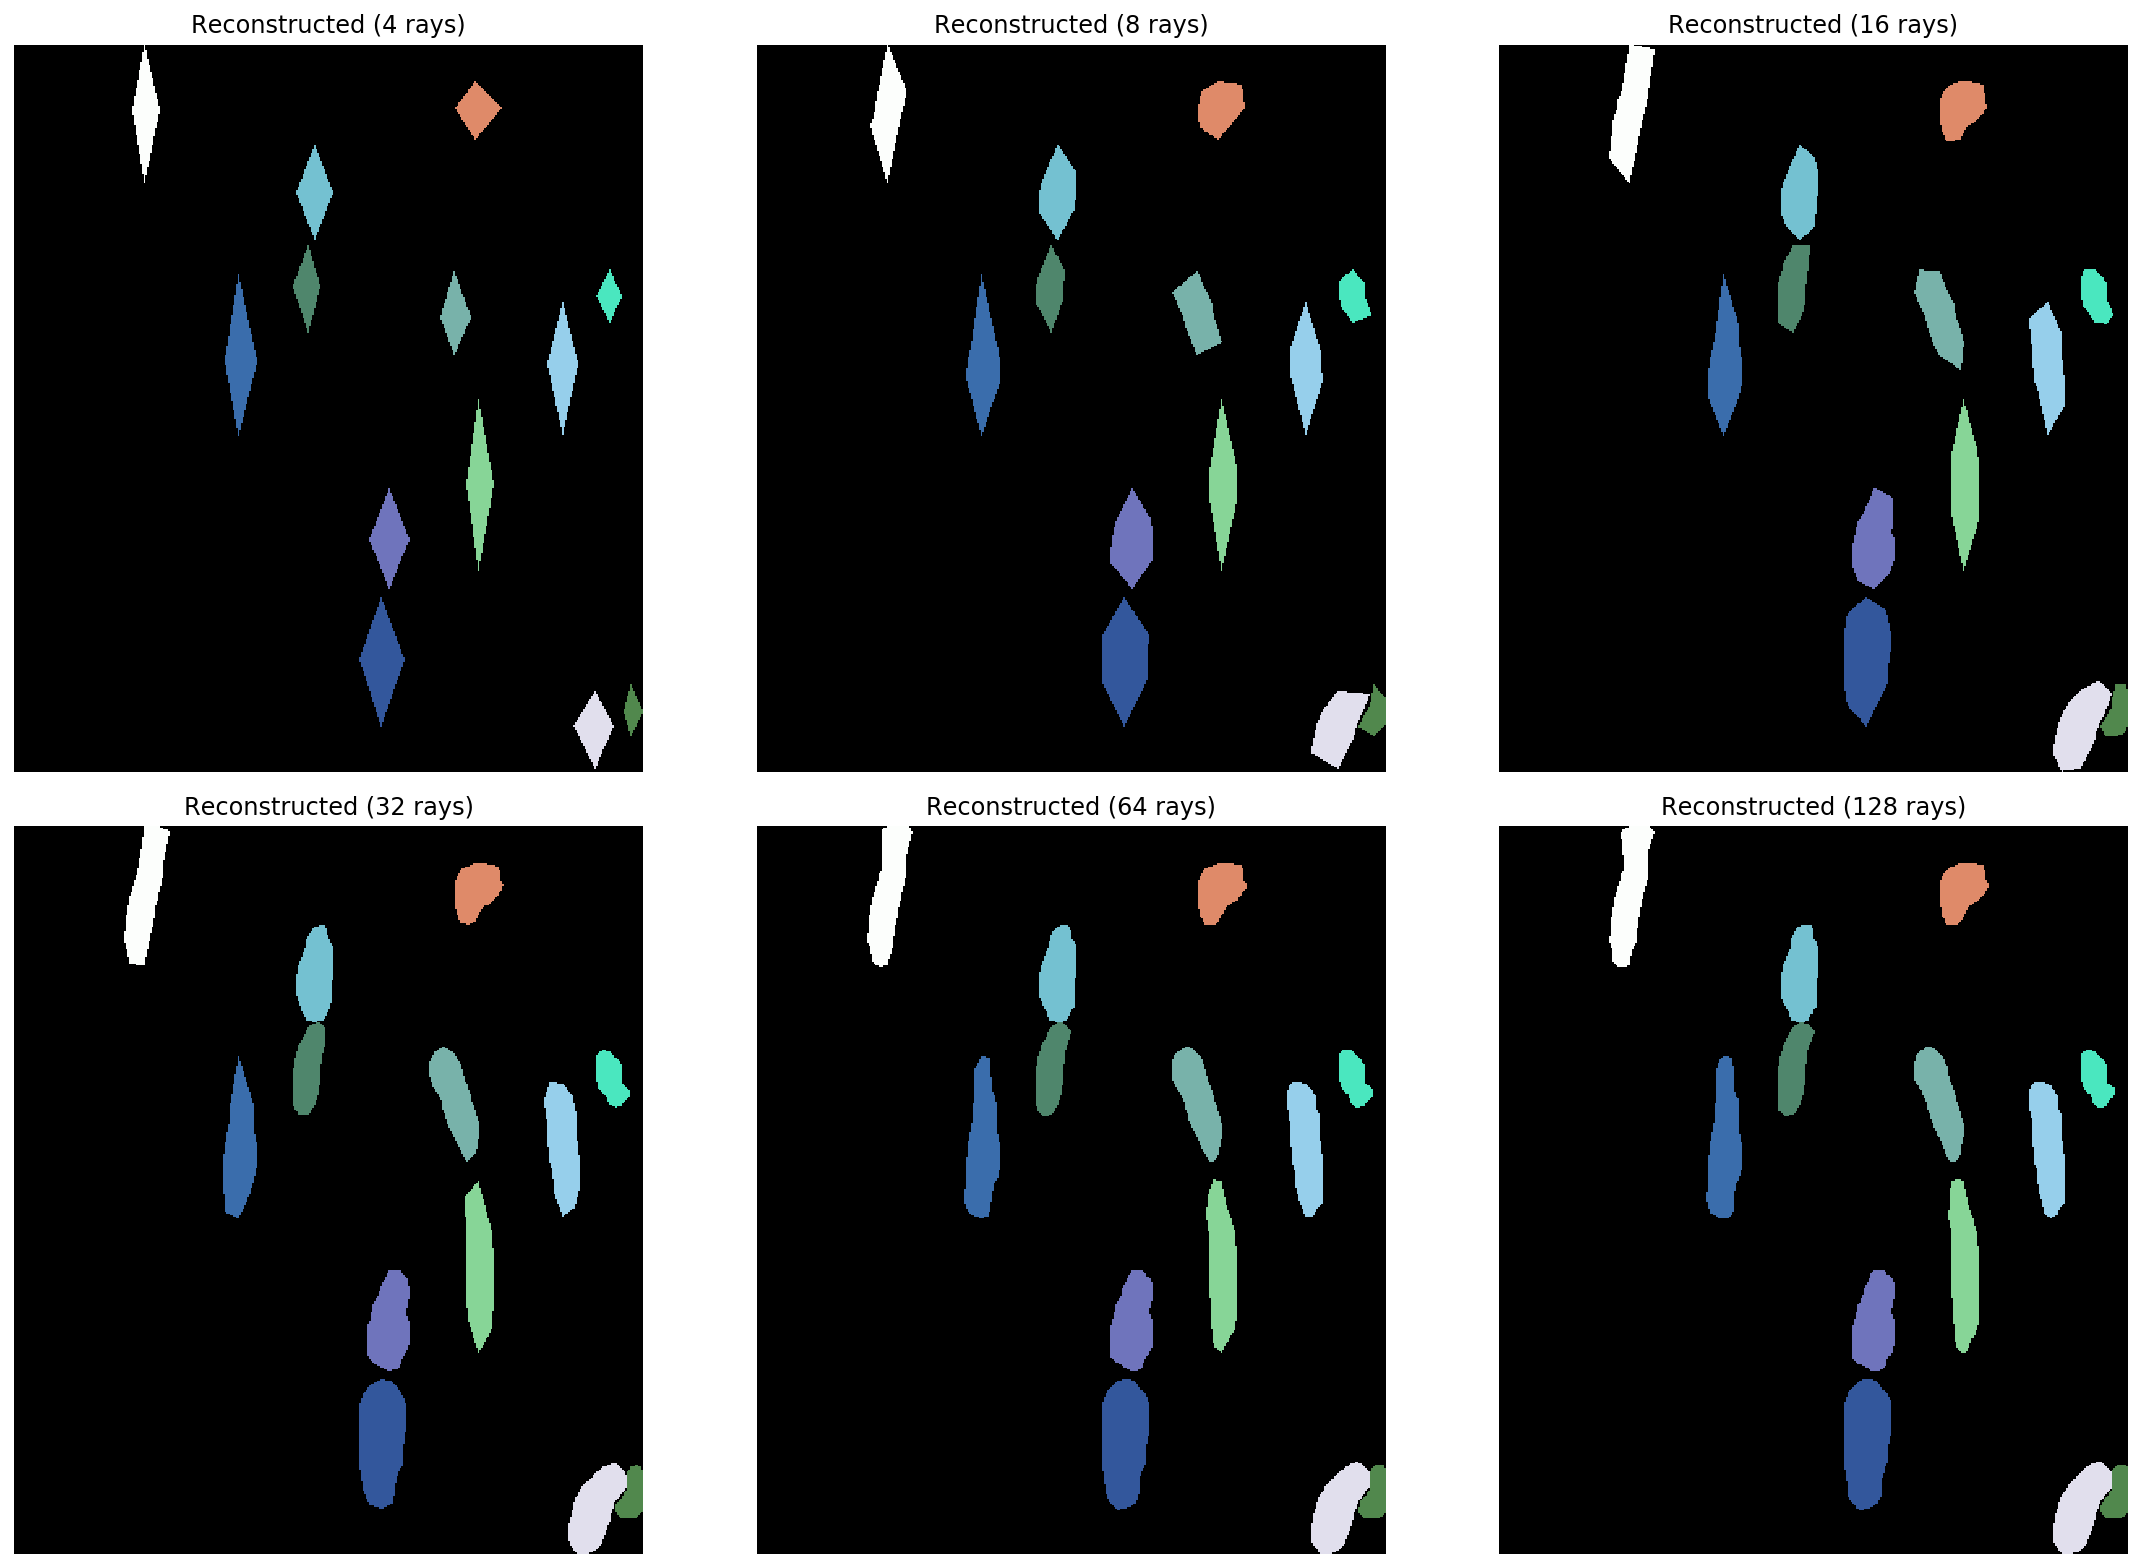

In [12]:
fig, ax = plt.subplots(2,3, figsize=(16,11))
for a,r in zip(ax.flat,n_rays):
    a.imshow(relabel_image_stardist(lbl, n_rays=r), cmap=lbl_cmap)
    a.set_title('Reconstructed (%d rays)' % r)
    a.axis('off')
plt.tight_layout();